In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass, replace
from pyvis.network import Network
from pyvis.options import Layout
import time

In [2]:
def phi(f, alpha):
    return 1 - (1-f)**alpha

In [3]:
@dataclass
class Block:
    id: int
    slot: int
    height: int
    parent: int
    leader: int

In [4]:
@dataclass
class NetworkParams:
    broadcast_delay_mean: int # second
    pol_proof_time: int # seconds
    # ---- blend network -- 
    blending_delay: int
    desimenation_delay_mean: float
    # desimenation_delay_var: float
    blend_hops: int
    no_network_delay: bool = False

    def sample_blending_delay(self):
        return np.random.uniform(0, self.blending_delay)

    def sample_desimenation_delay(self):
        return np.random.exponential(self.desimenation_delay_mean)
        # scale = self.desimenation_delay_var / self.desimenation_delay_mean
        # shape = self.desimenation_delay_mean / scale
        # return np.random.gamma(shape=shape, scale=scale)

    def sample_blend_network_delay(self):
        return sum(self.sample_blending_delay() + self.sample_desimenation_delay() for _ in range(self.blend_hops))
    
    def sample_broadcast_delay(self, blocks):
        return np.random.exponential(self.broadcast_delay_mean, size=blocks.shape)

    def block_arrival_slot(self, block_slot):
        if self.no_network_delay:
            return block_slot
        # return self.pol_proof_time + self.sample_mixnet_delay() + self.sample_broadcast_delay(block_slot) + block_slot
        return self.pol_proof_time + self.sample_blend_network_delay() + self.sample_broadcast_delay(block_slot) + block_slot

    def empirical_network_delay(self, N=10000, M=1000):
        return np.array([self.block_arrival_slot(np.zeros(M)) for _ in range(N)]).reshape(N*M)

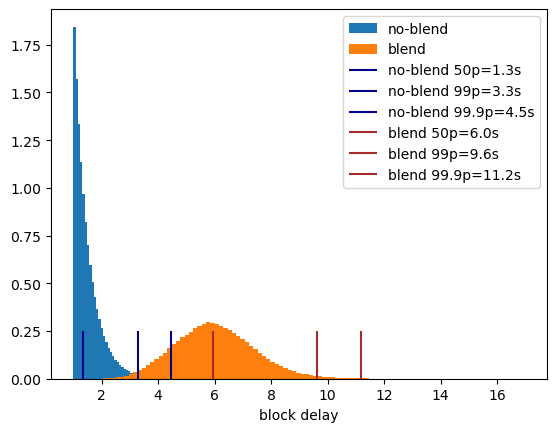

In [5]:
blend_net = NetworkParams(
    broadcast_delay_mean=0.5,
    pol_proof_time=1,
    blending_delay=2,
    desimenation_delay_mean=0.5,
    blend_hops=3,
)
no_blend_net = replace(blend_net, blend_hops=0)

N = 100
M = 10000
no_blend_samples = no_blend_net.empirical_network_delay()
no_blend_mean = no_blend_samples.mean()
blend_samples = blend_net.empirical_network_delay()
blend_mean = blend_samples.mean()

_ = plt.hist(no_blend_samples, bins=100, density=True, label="no-blend")
_ = plt.hist(blend_samples, bins=100, density=True, label="blend")

for p in [50, 99, 99.9]:
    no_blend_pct = np.percentile(no_blend_samples, p)
    _ = plt.vlines(no_blend_pct, ymin=0, ymax=0.25, color='darkblue', label=f"no-blend {p}p={no_blend_pct:.1f}s")

for p in [50, 99, 99.9]:
    blend_pct = np.percentile(blend_samples, p)
    _ = plt.vlines(blend_pct, ymin=0, ymax=0.25, color='brown', label=f"blend {p}p={blend_pct:.1f}s")
# _ = plt.vlines(blend_mean, ymin=0, ymax=1, color='brown', label=f"blend 50p={blend_mean:.1f}s")
# _ = plt.hist(blend_net.block_arrival_slot(np.zeros(1000)), bins=100, density=True, label="blend")
_ = plt.legend()
_ = plt.xlabel("block delay")

In [6]:
@dataclass
class Params:
    SLOTS: int
    f: float
    honest_stake: np.array
    adversary_control: float
    total_stake_estimate: float

    @property
    def N(self):
        return len(self.honest_stake) + 1

    @property
    def stake(self):
        return np.append(self.honest_stake, self.honest_stake.sum() / (1/self.adversary_control - 1))
    
    @property
    def relative_stake(self):
        return self.stake / self.total_stake_estimate

    def slot_prob(self):
        return phi(self.f, self.relative_stake)

In [7]:
class Sim:
    def __init__(self, params: Params, network: NetworkParams):
        self.params = params
        self.network = network
        self.leaders = np.zeros((params.N, params.SLOTS), dtype=np.int64)
        self.blocks = []
        max_number_of_blocks = int(3 * params.SLOTS * params.f)
        self.block_slots = np.zeros(max_number_of_blocks, dtype=np.int64)
        self.block_heights = np.zeros(max_number_of_blocks, dtype=np.int64)
        self.block_arrivals = np.zeros(shape=(params.N, max_number_of_blocks), dtype=np.int64) # arrival time to each leader for each block
        self.block_arrivals[:,:] = self.params.SLOTS
        # self.block_arrivals = np.zeros(shape=(params.N, 0), dtype=np.int64) # arrival time to each leader for each block

    
    def emit_block(self, leader, slot, height, parent):
        assert type(leader) in [int, np.int64]
        assert type(slot) in [int, np.int64]
        assert type(height) in [int, np.int64]
        assert type(parent) in [int, np.int64]

        block = Block(
            id=len(self.blocks),
            slot=slot,
            height=height,
            parent=parent,
            leader=leader,
        )
        self.blocks.append(block)
        self.block_slots[block.id] = block.slot
        self.block_heights[block.id] = block.height
    
        # decide when this block will arrive at each node
        new_block_arrival_by_node = self.network.block_arrival_slot(np.repeat(block.slot, self.params.N))

        if parent != -1:
            # the new block cannot arrive before it's parent
            parent_arrival_by_node = self.block_arrivals[:,parent]
            new_block_arrival_by_node = np.maximum(new_block_arrival_by_node, parent_arrival_by_node)

        self.block_arrivals[:,block.id] = new_block_arrival_by_node
        # self.block_arrivals = np.append(self.block_arrivals, new_block_arrival_by_node.reshape((self.params.N, 1)), axis=1)

        return block.id

    def emit_leader_block(self, leader, slot):
        assert type(leader) in [int, np.int64], type(leader)
        assert isinstance(slot, int)

        parent = self.fork_choice(leader, slot)
        return self.emit_block(
            leader,
            slot,
            height=self.blocks[parent].height + 1,
            parent=parent,
        )

    def fork_choice(self, leader, slot):
        assert type(leader) in [int, np.int64], type(leader)
        assert isinstance(slot, int)
        arrived_blocks = (self.block_arrivals[leader, :len(self.blocks)] <= slot) * self.block_heights[:len(self.blocks)]
        concurrent = (arrived_blocks == np.max(arrived_blocks)).nonzero()[0]
        return np.random.choice(concurrent)

    def plot_spacetime_diagram(self, MAX_SLOT=1000):
        alpha_index = sorted(range(self.params.N), key=lambda n: self.params.relative_stake[n])
        nodes = [f"$N_{n}$($\\alpha$={self.params.relative_stake[n]:.2f})" for n in alpha_index]
        messages = [(nodes[alpha_index.index(self.blocks[b].leader)], nodes[alpha_index.index(node)], self.blocks[b].slot, arrival_slot, f"$B_{{{b}}}$") for b, arrival_slots in enumerate(self.block_arrivals[:,:len(self.blocks)].T) for node, arrival_slot in enumerate(arrival_slots) if arrival_slot < MAX_SLOT]
    
        fig, ax = plt.subplots(figsize=(8,4))
        
        # Plot vertical lines for each node
        max_slot = max(s for _,_,start_t, end_t,_ in messages for s in [start_t, end_t])
        for i, node in enumerate(nodes):
            ax.plot([i, i], [0, max_slot], 'k-', linewidth=0.1)
            ax.text(i, max_slot + 30 * (0 if i % 2 == 0 else 1), node, ha='center', va='bottom')
        
        # Plot messages
        colors = plt.cm.rainbow(np.linspace(0, 1, len(messages)))
        for (start, end, start_time, end_time, label), color in zip(messages, colors):
            start_idx = nodes.index(start)
            end_idx = nodes.index(end)
            ax.annotate('', xy=(end_idx, end_time), xytext=(start_idx, start_time),
                        arrowprops=dict(arrowstyle='->', color="black", lw=0.5))
            placement = 0
            mid_x = start_idx * (1 - placement) + end_idx * placement
            mid_y = start_time * (1 - placement) + end_time * placement
            ax.text(mid_x, mid_y, label, ha='center', va='center', 
                    bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))
        
        ax.set_xlim(-1, len(nodes))
        ax.set_ylim(0, max_slot + 70)
        ax.set_xticks(range(len(nodes)))
        ax.set_xticklabels([])
        # ax.set_yticks([])
        ax.set_title('Space-Time Diagram')
        ax.set_ylabel('Slot')
        
        plt.tight_layout()
        plt.show()

    def honest_chain(self):
        chain_head = max(self.blocks, key=lambda b: b.height)
        honest_chain = {chain_head.id}
        
        curr_block = chain_head
        while curr_block.parent >= 0:
            honest_chain.add(curr_block.parent)
            curr_block = self.blocks[curr_block.parent]
        return sorted(honest_chain, key=lambda b: self.blocks[b].height)

    def visualize_chain(self):
        honest_chain = self.honest_chain()
        print("Honest chain length", len(honest_chain))
        honest_chain_set = set(honest_chain)
        
        layout = Layout()
        layout.hierachical = True
        
        G = Network(width=1600, height=800, notebook=True, directed=True, layout=layout, cdn_resources='in_line')

        for block in self.blocks:
            # level = slot
            level = block.height
            color = "lightgrey"
            if block.id in honest_chain_set:
                color = "orange"

            G.add_node(int(block.id), level=level, color=color, label=f"{block.id},{block.slot}")
            if block.parent >= 0:
                G.add_edge(int(block.id), int(block.parent), width=2, color=color)
        
        return G.show("chain.html")

    def run(self, seed=None):
        from collections import defaultdict
        timings = defaultdict(float)
        start_t = time.time()
        if seed is not None:
            np.random.seed(seed)

        # emit the genesis block
        self.emit_block(
            leader=0,
            slot=0,
            height=1,
            parent=-1,
        )
        self.block_arrivals[:,0] = 0 # all nodes see the genesis block

        prep_t = time.time()


        for s in range(1, self.params.SLOTS):
            slot_start_t = time.time()
            # the adversary will not participate in the simulation
            # (implemented by never delivering blocks to the adversary)
            # self.block_arrivals[-1,:] = self.params.SLOTS

            self.leaders[:,s] = np.random.random(size=self.params.N) < self.params.slot_prob()
            leader_lottery_t = time.time()

            for leader in np.nonzero(self.leaders[:,s])[0]:
                lead_start_t = time.time()
                if self.params.adversary_control is not None and leader == self.params.N - 1:
                    continue
                
                parent = self.fork_choice(leader, s)
                fork_choice_t = time.time()
                
                self.emit_block(
                    leader,
                    s,
                    height=self.blocks[parent].height + 1,
                    parent=parent,
                )
                emit_leader_block_t = time.time()

                timings["forkchoice"] += fork_choice_t - lead_start_t
                timings["emit_leader_block"] += emit_leader_block_t - fork_choice_t
                    
                # self.emit_leader_block(leader, s)
            slot_end_t = time.time()
            timings["leader"] += leader_lottery_t - slot_start_t
            timings["emit"] += slot_end_t - leader_lottery_t
            timings["slot"] += slot_end_t - slot_start_t

        end_t = time.time()
        timings["prep"] = prep_t - start_t
        timings["total"] = end_t - start_t
        # for phase, duration in timings.items():
        #     print(f"{phase}\t{duration:.2f}s")

    def adverserial_analysis(self, should_plot=False, seed=0, k=2160):
        from collections import defaultdict

        timings = defaultdict(float)

        start_t = time.time()
        np.random.seed(seed)
        
        adversary = self.params.N-1 # adversary is always the last node in our simulations

        self.block_arrivals[adversary,:len(self.blocks)] = self.block_slots[:len(self.blocks)] # we will say the adversary receives the blocks immidiately

        honest_chain = self.honest_chain()
        
        honest_chain_t = time.time()
        
        honest_height_by_slot = np.zeros(self.params.SLOTS, dtype=np.int64)

        for block_id in honest_chain:
            honest_height_by_slot[self.blocks[block_id].slot] = 1
        honest_height_by_slot = honest_height_by_slot.cumsum()
        
        honest_height_by_slot_t = time.time()
        
        reorg_depths = []
        if should_plot:
            plt.figure(figsize=(20, 6))
            ax = plt.subplot(121)
            advantage = np.zeros(self.params.SLOTS)
        
        adversary_active_slots = np.random.random(size=self.params.SLOTS) < phi(self.params.f, self.params.relative_stake[adversary])
        adversary_cumsum = adversary_active_slots.cumsum()

        all_active_slots = (self.leaders.sum(axis=0) + adversary_active_slots) > 0
        slot_lookahead = int(3 * k / self.params.f)
    
        prep_t = time.time()
        timings["honest_chain"] += honest_chain_t - start_t
        timings["honest_height_by_slot"] += honest_height_by_slot_t - honest_chain_t
        timings["prep_analysis"] += prep_t - start_t
        for b in range(len(self.blocks)):
            block_start_t = time.time()
            block = self.blocks[b]
            if block.id > 0 and block.id % 5000 == 0:
                print("Processing block", block)
            
            nearest_honest_block = block
            while nearest_honest_block.height >= len(honest_chain) or honest_chain[nearest_honest_block.height-1] != nearest_honest_block.id:
                nearest_honest_block = self.blocks[nearest_honest_block.parent]

            nearest_honest_t = time.time()
            
            cumulative_rel_height = adversary_cumsum[block.slot+1:block.slot+1 + slot_lookahead] - adversary_cumsum[block.slot]

            adverserial_height_by_slot = block.height + cumulative_rel_height

            honest_height_by_slot_lookahead = honest_height_by_slot[block.slot + 1:block.slot+1 + slot_lookahead]
        
            adverserial_wins = adverserial_height_by_slot > honest_height_by_slot_lookahead
        
            reorg_events = adverserial_wins & all_active_slots[block.slot+1:block.slot+1 + slot_lookahead]

                
            reorg_events_t = time.time()
            reorg_depth = honest_height_by_slot_lookahead[reorg_events] - nearest_honest_block.height
            reorg_depth_t = time.time()
            reorg_depths += list(reorg_depth)
            block_end_t = time.time()
            timings["nearest_honest"] += nearest_honest_t - block_start_t
            timings["reorg_events"] += reorg_events_t - nearest_honest_t
            timings["reorg_depth"] += reorg_depth_t - reorg_events_t
            timings["depth_append"] += block_end_t - reorg_depth_t
            
            if should_plot:
                if reorg_events.sum() > 0:
                    first_slot = block.slot+1
                    last_slot = first_slot + np.nonzero(reorg_events)[0].max() + 1
                    advantage[first_slot:last_slot] = np.maximum(advantage[first_slot:last_slot], adverserial_height_by_slot[:last_slot-first_slot]-honest_height_by_slot[first_slot:last_slot])

        for phase, duration in timings.items():
            print(f"{phase}\t{duration:.2f}s")
                    
        if should_plot:
            ax.plot(advantage, color='k', lw="0.5")
            _ = ax.set_title(f"max chain weight with adversery controlling {self.params.relative_stake[adversary] * 100:.0f}% of stake")
            _ = ax.set_ylabel("adversary height advantage")
            _ = ax.set_xlabel("slot")
            _ = ax.legend()

            ax = plt.subplot(122)
            _ = ax.grid(True)
            _ = ax.hist(reorg_depths, density=False, bins=100)
            _ = ax.set_title(f"re-org depth with {self.params.relative_stake[adversary] * 100:.0f}% adversary")
            _ = ax.set_xlabel("re-org depth")
            _ = ax.set_ylabel("frequency")
        return reorg_depths

In [8]:
def multi_epoch_sim(params: Params, network: NetworkParams, beta: float, epochs: int):
    stake_estimate = params.total_stake_estimate
    sims = []
    for j in range(epochs):
        print(f"simulating epoch {j}")
        sim = Sim(
            params=replace(params, total_stake_estimate=stake_estimate),
            network=network,
        )
        sim.run()
        sims.append(sim)
    
        honest = sim.honest_chain()
        honest_slots = np.array([sim.blocks[b].slot for b in honest])
        
        error = 1 - len(honest) / (params.SLOTS * params.f)
        h = beta * stake_estimate
        stake_estimate = stake_estimate - h * error

    return sims

# Bias

$\boxed{\langle D_{\infty}\rangle=\frac{\log(1-f)}{\log(1-f/q)} D^0[\mathbf{w}]}$

In [9]:
def network_bias(sim: Sim):
    f = sim.params.f
    honest_chain_growth_rate = len(sim.honest_chain()) / (sim.params.SLOTS * f)
    wasted_block_rate = (len(sim.blocks) - len(sim.honest_chain())) / (sim.params.SLOTS * f)
    q = (1 - wasted_block_rate)
    print(q)
    return np.log(1 - f) / np.log(1 - (f / q))

# Variance Plots

In [10]:
stake_real = np.random.pareto(10, 100)
f = 1/30
params = Params(
    SLOTS=int(6 * 2160 / f),
    f=f,
    adversary_control = 10 ** -9,
    honest_stake = stake_real,
    total_stake_estimate = stake_real.sum(),
)

expected_q = 0.85
optimal_beta = f / ((expected_q - f) * np.log(1/(1-f/expected_q)))
betas = np.linspace(optimal_beta*0.50, optimal_beta*1.5, 10)
vary_betas = [multi_epoch_sim(
    params=params,
    network=blend_net,
    beta=beta,
    epochs=50
) for beta in betas]

simulating epoch 0
simulating epoch 1
simulating epoch 2
simulating epoch 3
simulating epoch 4
simulating epoch 5
simulating epoch 6
simulating epoch 7
simulating epoch 8
simulating epoch 9
simulating epoch 10
simulating epoch 11
simulating epoch 12
simulating epoch 13
simulating epoch 14
simulating epoch 15
simulating epoch 16
simulating epoch 17
simulating epoch 18
simulating epoch 19
simulating epoch 20
simulating epoch 21
simulating epoch 22
simulating epoch 23
simulating epoch 24
simulating epoch 25
simulating epoch 26
simulating epoch 27
simulating epoch 28
simulating epoch 29
simulating epoch 30
simulating epoch 31
simulating epoch 32
simulating epoch 33
simulating epoch 34
simulating epoch 35
simulating epoch 36
simulating epoch 37
simulating epoch 38
simulating epoch 39
simulating epoch 40
simulating epoch 41
simulating epoch 42
simulating epoch 43
simulating epoch 44
simulating epoch 45
simulating epoch 46
simulating epoch 47
simulating epoch 48
simulating epoch 49
simulating

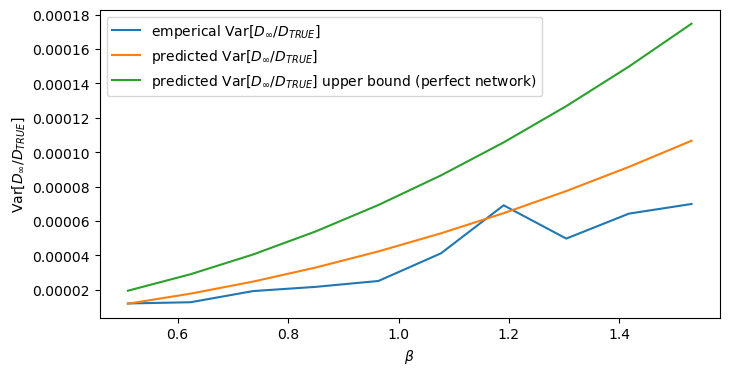

In [15]:

D_true = stake_real.sum()
var = np.array([np.array([s.params.total_stake_estimate / D_true for s in sims[10:]]).var() for sims in vary_betas])

plt.figure(figsize=(8, 4))

plt.plot(betas, var, label="emperical Var[$D_\\infty / D_{TRUE}$]")

sim = vary_betas[0][0]
f = sim.params.f
T = sim.params.SLOTS
q = expected_q

plt.plot(betas, [(beta / f)**2 * q / T * (np.log(1 - f) / np.log(1 - f/q))**2 * (1-f) * f for beta in betas], label="predicted Var[$D_\\infty / D_{TRUE}$]")
plt.plot(betas, [(beta / f)**2  / T * (1 - f) * f for beta in betas], label="predicted Var[$D_\\infty / D_{TRUE}$] upper bound (perfect network)")

plt.ylabel("Var[$D_\\infty / D_{TRUE}$]")
plt.xlabel("$\\beta$")
plt.legend()